<a href="https://colab.research.google.com/github/johanhoffman/methods-in-computational-science/blob/main/MICS_Integration_theoahfeldt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Integration
**Theo Puranen Åhfeldt**

# **Abstract**

The objective of this report is to implement methods for approximating integrals. This includes the deterministic Gauss quadrature rule over the unit interval and over a reference triangle. It also includes the stochastic Monte Carlo quadrature based on uniform sampling over the same domains. The implementations are tested against scipy's integration module, which indicates that the implementations are succesful.

# **About the code**

This report is written by Theo Puranen Åhfeldt based on a template by Johan Hoffman.

In [12]:
# Copyright (C) 2020,2021 Johan Hoffman (jhoffman@kth.se)
# Copyright (C) 2021 Theo Puranen Åhfeldt (tahfeldt@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This file is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

# **Set up environment**

To have access to the neccessary modules you have to run this cell.

In [13]:
# Load neccessary modules.
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

# **Introduction**

Quadrature rules approximate an integral by evaluating the function at $q + 1$ different quadrature points $x_i$ and taking a weigthed average.
$$\int_{\Omega} f(x) dx \approx \sum_{i = 0}^q f(x_i)w_i$$
Another way of approximating integrals is Monte Carlo integration. This works by taking $n$ samples $x_i$ from the uniform distribution $U(D)$ where $D$ is the domain of the integration.
$$\int_D g(x) dx \approx \frac{|D|}{n} \sum_{i=1}^n g(x_i)$$

# **Method**

The theory behind the quadrature is more complex then the actual rules themselves. This makes implementation a straight forward process of transforming simple arithmetic expressions to code. The uniform sampling required for Monte Carlo integration is implemented using the `numpy.random` module. The quadrature rules are tested on randomly genereted polynomials for which they should be exact, by comparing against integration using the `scipy.integrate` module. The Monte Carlo integration is tested that it converges to the right value (as defined by `scipy.integrate`) and that it does so at a rate of $1/\sqrt{n}$.

## 2-point Gauss quadrature over a unit interval

An integral over the interval $[-1, 1]$ can be approximated using the 2-point quadrature rule as follows:
$$\int_{-1}^1 f(x) \approx f(x_0)w_0 + f(x_1)w_1,\quad w_0=w_1=1,\quad x_0 = \frac{1}{\sqrt{3}}, x_1 = -\frac{1}{\sqrt{3}}$$

Using the map $F: [-1,1] \to [0,1]$, we can translate this rule to:

$$\int_0^1 f(x) \approx f(x_0)w_0 + f(x_1)w_1,\quad w_0=w_1=\frac{1}{2},\quad x_0 = \frac{1}{2} + \frac{1}{2\sqrt{3}}, x_1 = \frac{1}{2} - \frac{1}{2\sqrt{3}}$$

For more details see problem 11.3. Using this new rule the implementation is very straight forward.

In [14]:
def gauss_quadrature_unit_interval(f):
    c = 1/(2*np.sqrt(3))
    x_0, x_1 = 0.5 + c, 0.5 - c
    return (f(x_0) + f(x_1))/2

### Tests

To verify the implementation we compare the Gauss quadrature against scipy's integration on randomly generated polynomials. We only test on quadratic polynomials for which the 2-point quadrature should be exact.

In [15]:
def verify_gauss_quadrature_unit_interval(p):
    assert np.abs(integrate.quad(p, 0, 1)[0] - gauss_quadrature_unit_interval(p)) < 1e-10

def test_gauss_quadrature_unit_interval(num_tests):
    for _ in range(num_tests):
        p = np.polynomial.polynomial.Polynomial(np.random.random((4,)))
        verify_gauss_quadrature_unit_interval(p)

## 3-point edge midpoint quadrature over a reference triangle

Using the reference triangle defined by the vertices $(0, 0)$, $(1, 0)$ and $(0, 1)$, we have the three edge midpoint quadrature points $(0, \frac{1}{2})$, $(\frac{1}{2}, 0)$ and $(\frac{1}{2}, \frac{1}{2})$ with weights $w_0 = w_1 = w_2 = \frac{1}{6}$ (by example 11.5). The implementation is thus simply evaluation at these points in addition to weighing.

In [16]:
def quadrature_reference_triangle(f):
    return (f(0, 0.5) + f(0.5, 0) + f(0.5, 0.5))/6

### Tests

We verify the implementation by comparing against scipy's integration on randomly generated polynomials on the form $ax^2 + by^2 + cxy + dx + ey + f$.

In [17]:
def verify_quadrature_reference_triangle(p):
    ref = integrate.dblquad(p, 0, 1, 0, lambda x: 1 - x)[0]
    assert np.abs(ref - quadrature_reference_triangle(p)) < 1e-10
    
def test_quadrature_reference_triangle(num_tests):
    for _ in range(num_tests):
        c = np.random.random((3,3))
        c[2,2] = 0
        c[2,1] = 0
        c[1,2] = 0
        p = lambda y, x: np.polynomial.polynomial.polyval2d(x, y, c)
        verify_quadrature_reference_triangle(p)

## Monte Carlo quadrature over a unit interval

`numpy.random.random` gives an array of samples picked uniformly over the interval $[0,1)$ which is equivalent to the unit interval $[0,1]$ when it comes to integration. To perform Monte Carlo integration, we simply evaluate the function at every sample, divide by the number of samples, and multiply by $|[0,1]| = 1$.

In [18]:
def monte_carlo_quadrature_unit_interval(f, num_samples):
    return np.sum(f(np.random.random((num_samples,)))) / num_samples

### Tests

To test the implementation we run it using different sample sizes, and plot the absolute error. We also plot the function $0.1/\sqrt{n}$ to compare against.

In [19]:
def test_monte_carlo_quadrature_unit_interval(test_func):
    ref = integrate.quad(test_func, 0, 1)[0]
    size = np.array(range(4,101))*100
    ints = [np.abs(ref - monte_carlo_quadrature_unit_interval(test_func, x)) for x in size]
    plt.plot(size, ints)
    plt.plot(size, 0.1/np.sqrt(size))
    plt.show()

## Monte Carlo quadrature over a reference triangle

We use the same reference triangle as before. In order to pick a sample uniformly over the reference triangle, we use a triangular distribution to pick the x-coordinate, and then pick the y-coordinate as a uniform distribution between 0 and the height of the triangle at the previously picked x-coordinate. Once we have our samples we evaluate the function over each, divide by the number of samples and multiply with the area of the triangle which is $1/2$.

In [20]:
def monte_carlo_quadrature_reference_triangle(f, num_samples):
    xs = np.random.triangular(0, 0, 1, num_samples)
    ys = (1 - xs) * np.random.random(num_samples)
    return np.sum(np.array([f(x,y) for (x, y) in zip(xs, ys)]) / (2 * num_samples))

### Tests

To test the implementation we run it using different sample sizes, and plot the absolute error. We also plot the function $0.1/\sqrt{n}$ to compare against.

In [21]:
def test_monte_carlo_quadrature_reference_triangle(test_func):
    ref = integrate.dblquad(test_func, 0, 1, 0, lambda x: 1 - x)[0]
    size = np.array(range(4,101))*100
    ints = [np.abs(ref - monte_carlo_quadrature_reference_triangle(test_func, x)) for x in size]
    plt.plot(size, ints)
    plt.plot(size, 0.1/np.sqrt(size))
    plt.show()

# **Results**

The following code cell tests and shows that the deterministic quadrature rules are exact for the tested polynomials:

In [22]:
test_gauss_quadrature_unit_interval(100)
test_quadrature_reference_triangle(100)
print("OK! All tests completed")

OK! All tests completed


The following code cells shows that the Monte Carlo quadratures convergence to the right value.

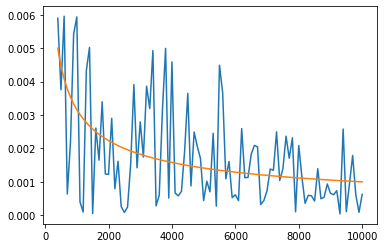

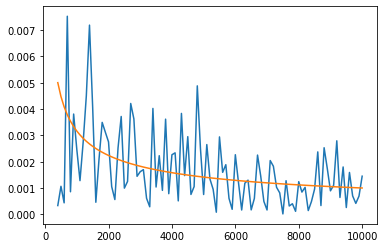

In [23]:
test_monte_carlo_quadrature_unit_interval(np.cos)
test_monte_carlo_quadrature_reference_triangle(lambda x, y: np.sin(x) + np.cos(y))

# **Discussion**

The Monte Carlo quadrature is quite sporadic in terms of its accuracy, which is to be expected for a stochastic method. One could possibly run it several times and plot the average errors to get a smoother curve, but I think the trend is clear enough in the current plots to see that it converges at the expected rate.